In [1]:
import numpy as np
import pandas as pd
import json
import pickle

import warnings

#import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.utils.data

In [2]:
data_df = pd.read_pickle('datasets/all_players_rel_all_actions_group_team.pkl')

data_df.loc[:, 'next_action'] = data_df.groupby('playIndex').action.shift(-1)

# drop na if using sarsa model
sarsa_df = data_df.dropna(axis=0, how='any', inplace=False)

print(len(data_df) - len(sarsa_df))

print(sarsa_df.head())

4273
   playIndex  timeIndex                                              state  \
0          0         48  [11.4, 42.67, 0.2, 3.07, 102.1, 312.17, 12.42,...   
1          0         49  [11.39, 42.66, 0.21, 2.84, 105.48, 199.45, 11....   
2          0         50  [11.41, 42.63, 0.47, 2.53, 113.86, 168.36, 11....   
3          0         51  [11.45, 42.56, 0.83, 2.53, 110.69, 158.32, 11....   
4          0         52  [11.53, 42.45, 1.32, 3.03, 117.3, 148.06, 11.1...   

                                          next_state  reward         action  \
0  [11.39, 42.66, 0.21, 2.84, 105.48, 199.45, 11....    0.01   [0.01, 0.01]   
1  [11.41, 42.63, 0.47, 2.53, 113.86, 168.36, 11....    0.04  [-0.02, 0.03]   
2  [11.45, 42.56, 0.83, 2.53, 110.69, 158.32, 11....    0.08  [-0.04, 0.07]   
3  [11.53, 42.45, 1.32, 3.03, 117.3, 148.06, 11.1...    0.14  [-0.08, 0.11]   
4  [11.62, 42.32, 1.7, 3.13, 114.42, 144.84, 11.5...    0.16  [-0.09, 0.13]   

     next_action  
0  [-0.02, 0.03]  
1  [-0.04, 0.

In [3]:
len(sarsa_df)

221174

In [4]:
#x = sarsa_df.loc[1:2, 'state']

#stacked = np.stack(x.values)

#dl = torch.utils.data.DataLoader(sarsa_df)

In [5]:
# return batch_size of plays
def sample_from_plays(batch_size, df, seed):
    
    np.random.seed(seed)
    
    indices = np.random.choice(len(df), batch_size, replace=False)
    
    plays = df.iloc[indices, :]
    
    return plays

'''
Function that splits the data into a training, validation, and test set
'''
def split_data(dataset, train_split, seed):
    np.random.seed(seed)
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)

    train_num = int(len(dataset)*train_split)
    val_num = (len(dataset) - int(len(dataset)*train_split))//2

    train_indices = indices[0:train_num]
    val_indices = indices[train_num:train_num+val_num]
    test_indices = indices[train_num+val_num:]

    #check to make sure slices correct
    assert len(dataset) == len(train_indices) + len(val_indices) + len(test_indices)

    #dataset = help.normalize(train_indices, dataset)

    train_data = dataset.iloc[train_indices,:]
    val_data = dataset.iloc[val_indices,:]
    test_data = dataset.iloc[test_indices,:]

    return train_data, val_data, test_data
    

In [6]:
BATCH_SIZE = 64

train_data, val_data, test_data = split_data(sarsa_df, 0.7, 2430)

#train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
#val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


print(test_data.columns)

print(f"Length of training data: {len(train_data)}")

Index(['playIndex', 'timeIndex', 'state', 'next_state', 'reward', 'action',
       'next_action'],
      dtype='object')
Length of training data: 154821


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [8]:
'''
Neural Network that will represent the Q-function
Input: concatenated (state,action) pair
Output: value
'''

'''
class Qnet(nn.Module):
    def __init__(self, state_size, action_size):
        super(Qnet, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        self.linear1 = nn.Linear(state_size+action_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128,1)
        
        self.relu = nn.ReLU()
        
    def forward(self, inp):
        
        layer1_output = self.relu(self.linear1(inp))
        layer2_output = self.relu(self.linear2(layer1_output))
        layer3_output = self.relu(self.linear3(layer2_output))
        output = self.linear4(layer3_output)
        
        return output
'''

'''
class Qnet(nn.Module):
    def __init__(self, state_size, action_size):
        super(Qnet, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        #self.batch_initial = nn.BatchNorm1d(state_size+action_size)
        self.batch1 = nn.BatchNorm1d(128)
        
        self.linear1 = nn.Linear(state_size+action_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 1)
        
        self.relu = nn.ReLU()
        
    def forward(self, inp):
        
        #inp = self.batch_initial(inp)
        
        layer1_output = self.relu(self.batch1(self.linear1(inp)))
        layer2_output = self.relu(self.linear2(layer1_output))
        output = self.linear3(layer2_output)
        
        return output
'''

class Qnet(nn.Module):
    def __init__(self, state_size, action_size):
        super(Qnet, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
        
        #self.batch_initial = nn.BatchNorm1d(state_size+action_size)
        self.batch1 = nn.BatchNorm1d((state_size+action_size)*2)
        
        self.linear1 = nn.Linear(state_size+action_size, (state_size+action_size)*2)
        self.linear2 = nn.Linear((state_size+action_size)*2, 1)
        
        self.relu = nn.ReLU()
        
    def forward(self, inp):
        
        #inp = self.batch_initial(inp)
        
        layer1_output = self.relu(self.batch1(self.linear1(inp)))
        output = self.linear2(layer1_output)
        return output



In [11]:
# define hyperparameters
iterations = 25000
state_size = len(data_df.loc[0,'state'])
action_size = 2
gamma = 0.99

In [8]:


# create models
eval_net = Qnet(state_size, action_size).to(device=device)

for layer in eval_net.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

target_net = type(eval_net)(state_size, action_size).to(device=device)
target_net.load_state_dict(eval_net.state_dict())

# define loss function
loss_fn = nn.MSELoss()
# define optimizers
optimizer = optim.Adam(eval_net.parameters())

print(f"State size: {state_size}")

State size: 138


In [9]:
#for batch, labels in train_loader:
#    print(batch)
#    print(labels)
    
#    break

In [9]:

def test_loop(test_df, q_model, test_loss_fn, device):
    size = len(test_df)
    test_loss = 0
    q_model.eval()
    
    with torch.no_grad():
        for row_index in range(0,len(test_df)):
            #try:
            row = test_df.iloc[row_index, :]

            state = torch.tensor(row['state'], dtype=torch.float32).to(device=device)
            action = torch.tensor(row['action'], dtype=torch.float32).to(device=device)
            reward = torch.tensor(row['reward'], dtype=torch.float32).to(device=device)
            next_state = torch.tensor(row['next_state'], dtype=torch.float32).to(device=device)
            next_action = torch.tensor(row['next_action'], dtype=torch.float32).to(device=device)
            
            # do this because forget to replace nans in next state in dataset construction
            next_state = torch.nan_to_num(next_state, nan=0)

            # Update Q
            eval_input = torch.cat((state, action), 0)
            eval_input = torch.unsqueeze(eval_input, 0)
            q_eval = q_model(eval_input)

            target_input = torch.cat((next_state, next_action), 0)
            target_input = torch.unsqueeze(target_input, 0)
            q_target = reward + gamma*q_model(target_input)

            loss = test_loss_fn(q_eval, q_target)
            test_loss += loss
            #except Exception as e:
                #print(f"Row index: {row_index}")
                #print(F"Exception: {e}")
                #print(row)
    
        test_loss /= size
            #print(f"Avg loss: {test_loss:>8f} \n")

    return test_loss
        
#avg_test_loss = test_loop(test_data, eval_net, F.mse_loss, device)

In [11]:
########
### Random loss is .325604
### Use random weights as baseline
########
untrained_net = type(eval_net)(state_size, action_size).to(device=device)
untrained_net.load_state_dict(eval_net.state_dict())

<All keys matched successfully>

In [12]:


epochs = 2
break_var = False
loss_list = []

num_batches = int(len(train_data)/BATCH_SIZE)+1

print(f"Num batches: {num_batches}")

COPY_TARGETS_INDEX = int(num_batches/3)

for k in range(epochs):
    eval_net.train()
    with warnings.catch_warnings(record=True) as w:
        
        
        #warnings.simplefilter("error")
        
        for i in range(num_batches):
        
            # update weights of target network
            if i % COPY_TARGETS_INDEX == 0:
                target_net.load_state_dict(eval_net.state_dict())


            #play = sample_from_plays(BATCH_SIZE, train_data, seed=k)
            # get sample from data
            start_index = i*BATCH_SIZE
            end_index = min(len(train_data), (i+1)*BATCH_SIZE)
                            
            play = train_data.iloc[list(range(start_index, end_index)), :]

            state = torch.tensor(np.stack(play['state'].values), dtype=torch.float32).to(device=device)
            action = torch.tensor(np.stack(play['action'].values), dtype=torch.float32).to(device=device)
            reward = torch.tensor(play['reward'].values, dtype=torch.float32).to(device=device)
            next_state = torch.tensor(np.stack(play['next_state'].values), dtype=torch.float32).to(device=device)
            next_action = torch.tensor(np.stack(play['next_action'].values), dtype=torch.float32).to(device=device)
            
            # do this because forget to replace nans in next state in dataset construction
            next_state = torch.nan_to_num(next_state, nan=0)
            
            # Update Q
            eval_input = torch.cat((state, action), 1)
            q_eval = eval_net(eval_input)

            target_input = torch.cat((next_state, next_action), 1)
            q_target = torch.unsqueeze(reward,1) + gamma*target_net(target_input)

            loss = loss_fn(q_eval, q_target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i % int(num_batches/3) == 0) and (i != 0):
                avg_val_loss = test_loop(val_data, eval_net, F.mse_loss, device)
                loss_list.append((k,avg_val_loss))
                print(f"At epoch {k}, iter {i}: avg. val loss = {avg_val_loss}")
                eval_net.train()
                
            if len(loss_list) > 1:
                if loss_list[-1][1] > loss_list[-2][1]:
                    break_var = True
                    #break
                    
        #if break_var:
        #    break
        
        if len(w):
            print(f"Batch index {i}")
            print(f"warning: {w}")
        


Num batches: 2420
At epoch 0, iter 806: avg. val loss = 0.3155793249607086
At epoch 0, iter 1612: avg. val loss = 0.30880865454673767
At epoch 0, iter 2418: avg. val loss = 0.3017028272151947
At epoch 1, iter 806: avg. val loss = 0.3004000782966614
At epoch 1, iter 1612: avg. val loss = 0.29857560992240906
At epoch 1, iter 2418: avg. val loss = 0.29723474383354187


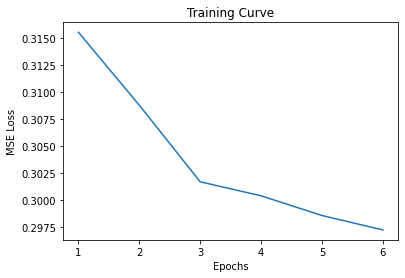

In [56]:
import matplotlib.pyplot as plt
import os

'''
metric (str): e.g. 'accuracy', 'loss'
'''
def plot_history(history_list, metric, filename):
    
    fig, ax = plt.subplots()

    # plotting
    ax.plot(list(range(1,len(history_list)+1)), history_list)
    plt.title("Training Curve")
    plt.xlabel("Epochs")
    plt.ylabel(f"{metric}")
    plt.show()

    #file_path = os.path.join(os.path.dirname(os.path.abspath(__file__)), filename)
    fig.savefig(filename)
    
loss_list = [0.3155793249607086, 0.30880865454673767, 0.3017028272151947, 0.3004000782966614, 0.29857560992240906, 0.29723474383354187]
    
plot_history(loss_list, 'MSE Loss', 'training_plots/val_loss.png')

In [13]:
torch.save(eval_net.state_dict(), 'model_files/sarsa_two.pt')
torch.save(untrained_net.state_dict(), 'model_files/sarsa_two_rb.pt')

In [14]:
#### compare random baseline on test data
test_loss_model = test_loop(test_data, eval_net, F.mse_loss, device)
test_loss_rb = test_loop(test_data, untrained_net, F.mse_loss, device)

print(f"Trained model test MSE: {test_loss_model}")
print(f"Random baseline model test MSE: {test_loss_rb}")


Trained model test MSE: 0.2949032485485077
Random baseline model test MSE: 18.92629051208496


In [12]:
eval_net = Qnet(state_size, action_size).to(device=device)
eval_net.load_state_dict(torch.load("model_files/sarsa_two.pt"))
eval_net.eval()

Qnet(
  (batch1): BatchNorm1d(280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=140, out_features=280, bias=True)
  (linear2): Linear(in_features=280, out_features=1, bias=True)
  (relu): ReLU()
)

In [108]:
eval_net.eval()

from scipy import stats

def test_quantile_for_play(df, row_index, num_simulations, verbose=False):

    sample_row = df.iloc[row_index,:]
    
    state = torch.tensor(sample_row['state'], dtype=torch.float32).to(device=device)
    action = torch.tensor(sample_row['action'], dtype=torch.float32).to(device=device)
    
    list_q_values = []
    list_actions = []
    q_value_dict = {}

    for k in range(num_simulations):


        radius = np.linalg.norm(sample_row['action']) * np.sqrt(np.random.uniform())

        theta = np.random.uniform()*2*np.pi

        sampled_action = np.array([radius*np.cos(theta), radius*np.sin(theta)])

        sampled_action = torch.tensor(sampled_action, dtype=torch.float32).to(device=device)

        simulated_input = torch.cat((state, sampled_action), 0)
        simulated_input = torch.unsqueeze(simulated_input, 0)
        sim_q_value = eval_net(simulated_input).cpu().detach()

        #print(f"Simulated Q-value: {output}")
        list_q_values.append(sim_q_value)
        list_actions.append(sampled_action)

        #simulated_q_values.append(output)
        q_value_dict[sim_q_value] = sampled_action

    true_value_input = torch.cat((state, action), 0)
    true_value_input = torch.unsqueeze(true_value_input, 0)
    true_output = eval_net(true_value_input).cpu().detach()
    
    list_q_values.append(true_output)
    list_actions.append(action)

    max_q = max(q_value_dict.keys())

    if verbose:
        print(f"True Q-value: {true_output}")
        print(f"True action: {sample_row['action']}")
        print(f"Max q-value from simulations: {max_q}")
        print(f"Max Q action: {q_value_dict[max_q]}")

    cpu_true_output = true_output.cpu().detach().numpy()
    cpu_keys = torch.stack(list(q_value_dict.keys())).reshape(-1).detach().cpu()

    percentile = stats.percentileofscore(cpu_keys, cpu_true_output, kind='weak')
    percentile_rank = stats.percentileofscore(cpu_keys, cpu_true_output, kind='rank')
    
    if verbose:
        print(f"Percentile (weak): {percentile}")
        print(f"Percentile (rank): {percentile_rank}")

        print(f"99th percentile {np.percentile(cpu_keys, 99)}")
        print(f"100th percentile {np.percentile(cpu_keys, 100)}")
        print(f"True q-val: {true_output}")
        
    return percentile_rank, list_q_values, list_actions



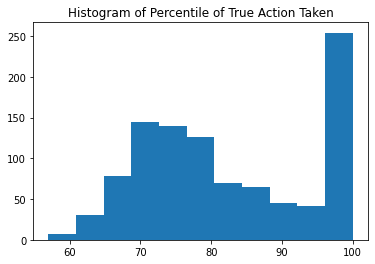

In [58]:
percentile_list = []
for i in range(1000):
    
    percentile_rank, q_list, action_list = test_quantile_for_play(test_data, i, 100)
    
    if percentile_rank > 100:
        print(f"at index {i} percentile rank {percentile_rank}")
        
    percentile_list.append(percentile_rank)

plt.hist(percentile_list, bins='auto')
plt.title("Histogram of Percentile of True Action Taken")
plt.show

plt.savefig("training_plots/quantile_hist.png")


[tensor([[0.8825]]), tensor([[0.8837]]), tensor([[0.8832]]), tensor([[0.8849]])]


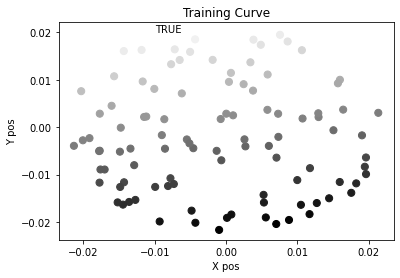

In [112]:
percentile_rank, q_list, action_list = test_quantile_for_play(test_data, 2, 100)

x_list = [action[0].detach().cpu() for action in action_list]
y_list = [action[1].detach().cpu() for action in action_list]
#x_list.append(action_list[-1][0])
#y_list.append(action_list[-1][1])

#q_list[-1] = q_list[-1].detach().cpu()

print(q_list[-4:])

#x_list.append(true_action[0])
#y_list.append(true_action[1])
#q_list.append()

fig, ax = plt.subplots()

ax.scatter(x_list, y_list, c=q_list, s=50, cmap='gray')
#ax.scatter(true_action[0], true_action[1], c='blue', s=50)
ax.annotate('TRUE', (action_list[-1][0], action_list[-1][1]))
plt.title("Training Curve")
plt.xlabel("X pos")
plt.ylabel("Y pos")
plt.show()



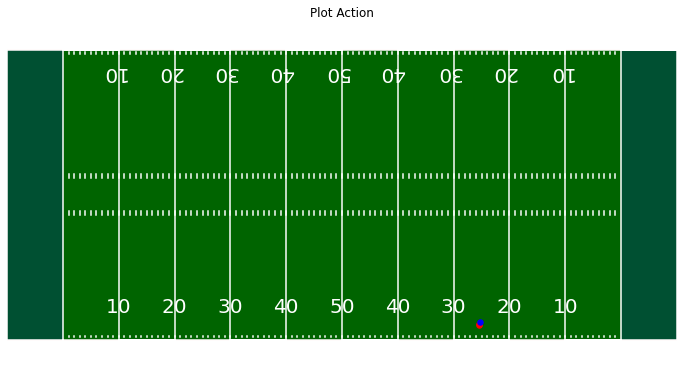

In [26]:


numpy_q_action = q_value_dict[max_q].cpu()

#first_entry = tracking2018.query('time == @time and gameId == @gameId')
fig, ax = create_football_field()
ax.scatter(x=sample_row['state'][0], y=sample_row['state'][1], color='red', s=30)
ax.scatter(x=sample_row['next_state'][0], y=sample_row['next_state'][1], color='red', s=30)
ax.scatter(x=sample_row['state'][0] + numpy_q_action[0], y=sample_row['state'][1] + numpy_q_action[1], color='blue', s=30)
plt.title('Plot Action')
#plt.legend()
plt.show()

In [16]:
import os
import seaborn as sns
import datetime

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

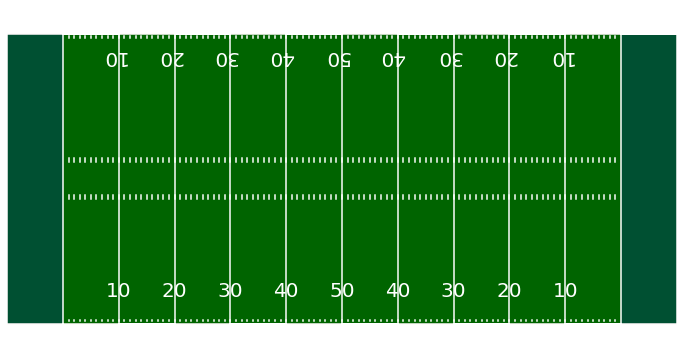

In [17]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

fig, ax = create_football_field()
plt.show()

In [ ]:
test_data.iloc[0,:]

In [ ]:
first_entry = tracking2018.query('time == @time and gameId == @gameId')
fig, ax = create_football_field()
first_entry.query("team == 'away'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='red', s=30, legend='Away')
first_entry.query("team == 'home'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
first_entry.query("displayName == 'football'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=50, legend='Football')
plt.title('Plot Teams')
plt.legend()
plt.show()